# Dec 28th, 2022 (SLC: mem + different thres)

**Motivation**: + Bar, Pie, etc (using multiples of 1/K as threshold) <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Fig dir

In [2]:
nn = 512
perc = 15
fig_dir = 'Fig5_Mem'
fig_dir = pjoin(fig_base_dir, 'paper2.0', f'n{nn}-p{perc}', fig_dir)
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512-p15/Fig5_Mem

## Prepare (512)

In [3]:
mice = Mice(nn, load_parcel=True)

## Results

### K = 7; use prune

In [4]:
%%time

num_k = 7
mu_vals = [
    np.round(e / num_k, 3)
    for e in [0.5, 1, 1.75, 3.5]
]
results = member_results(
    mice=mice,
    perc=perc,
    num_k=num_k,
    use_prune=True,
    merge_thres=0.444,
    n_resamples=int(1e5),
    mu_vals=mu_vals,
)
bt = BootStrap(**results['props_ca'])
list(results)

CPU times: user 17.6 s, sys: 4.09 s, total: 21.7 s
Wall time: 21.8 s


[
    'bt_dict',
    'props_bo',
    'props_ca',
    'pi_sorted',
    'mu_vals',
    'members',
    'reject',
    'scores'
]

In [5]:
results['mu_vals']

[0.071, 0.143, 0.25, 0.5]

In [6]:
from figures.fig_mem import mk_member_cmap
spectral, accent = mk_member_cmap()

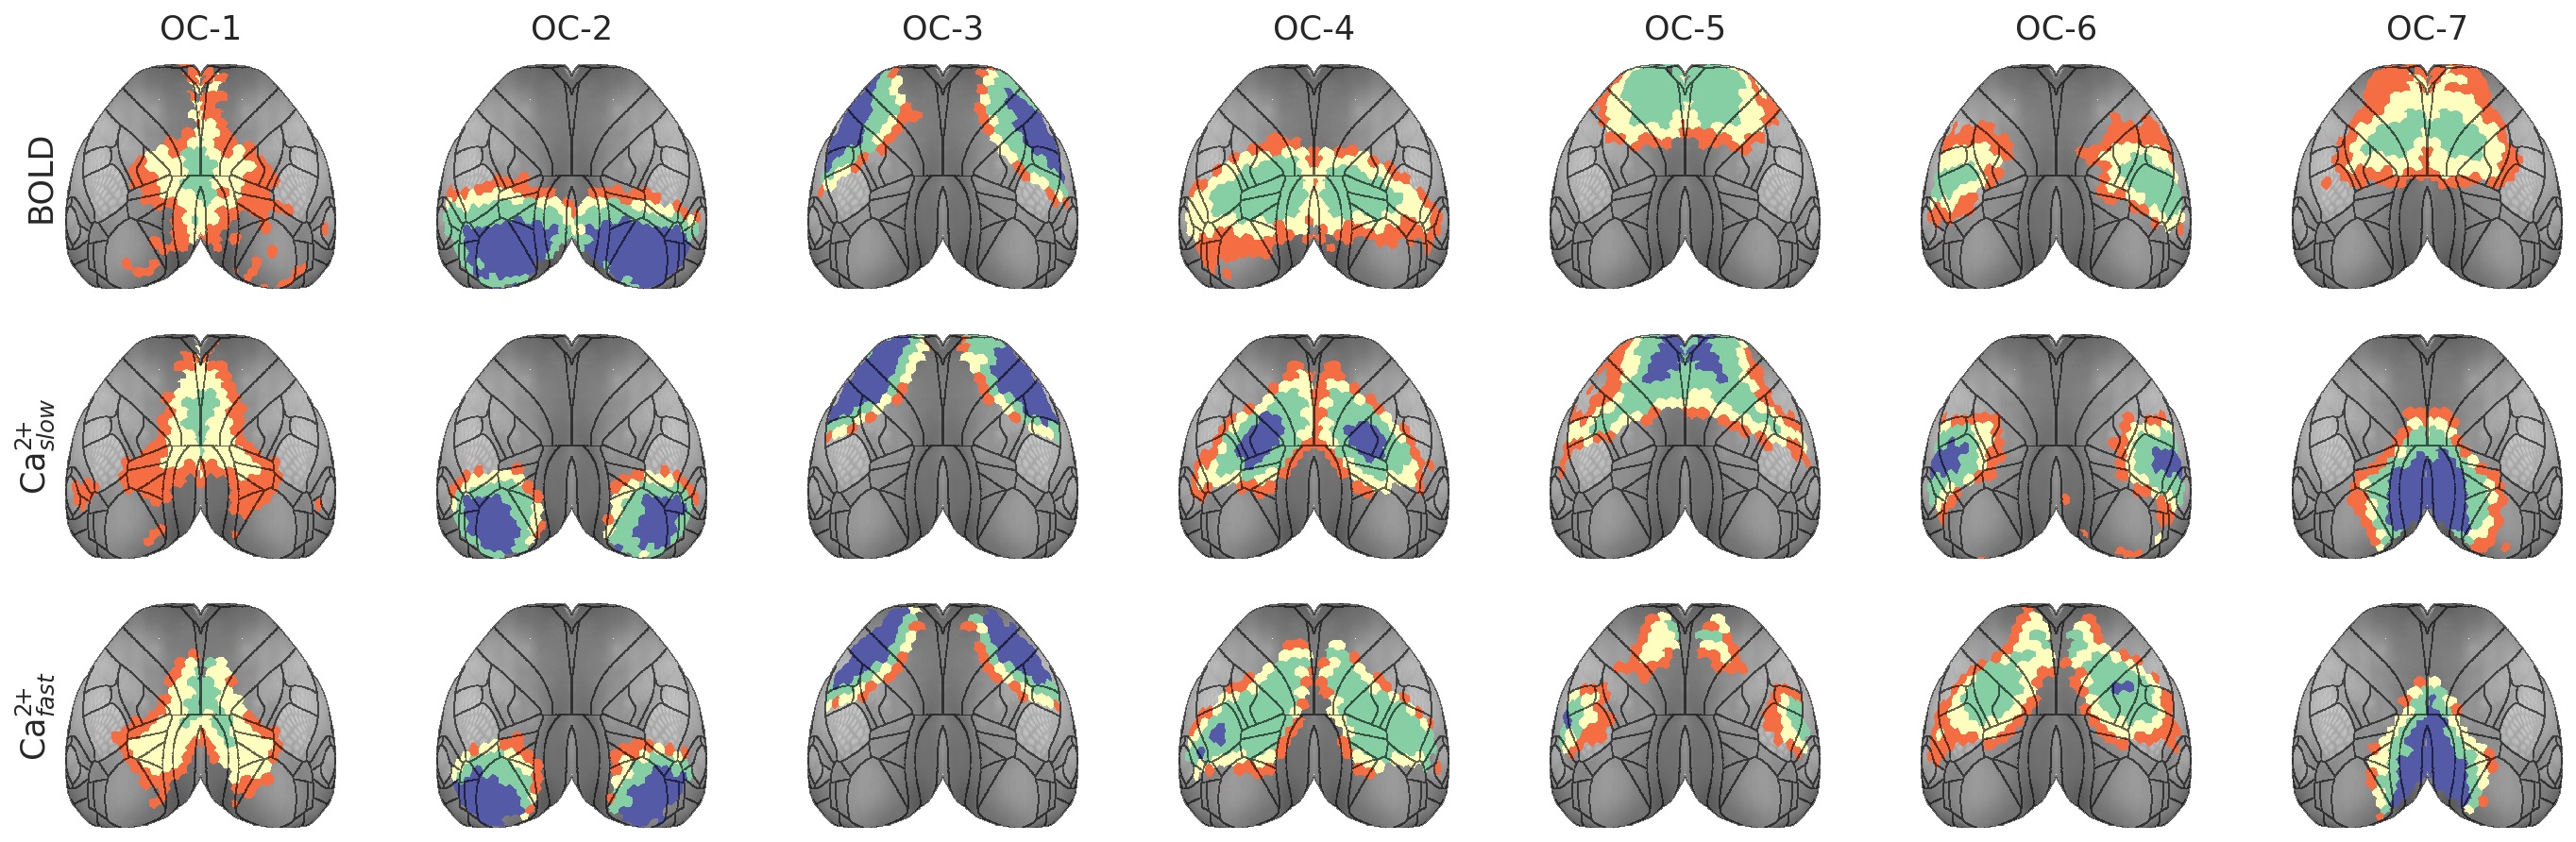

In [7]:
kws_show = {
    'vmin': 1,
    'vmax': len(results['mu_vals']),
    'interp': 'none',
    'cmap': spectral,
    'mask_thresh': 0.001,
    'contour_width': 0.2,
    'contour_alpha': 0.6,
    'contour_cmap': 'Greys_r',
    'contour_coarse': False,
    'add_disjoint': False,
    'add_title': True,
}
_ = bt.show(results['members'], dpi=150, **kws_show)

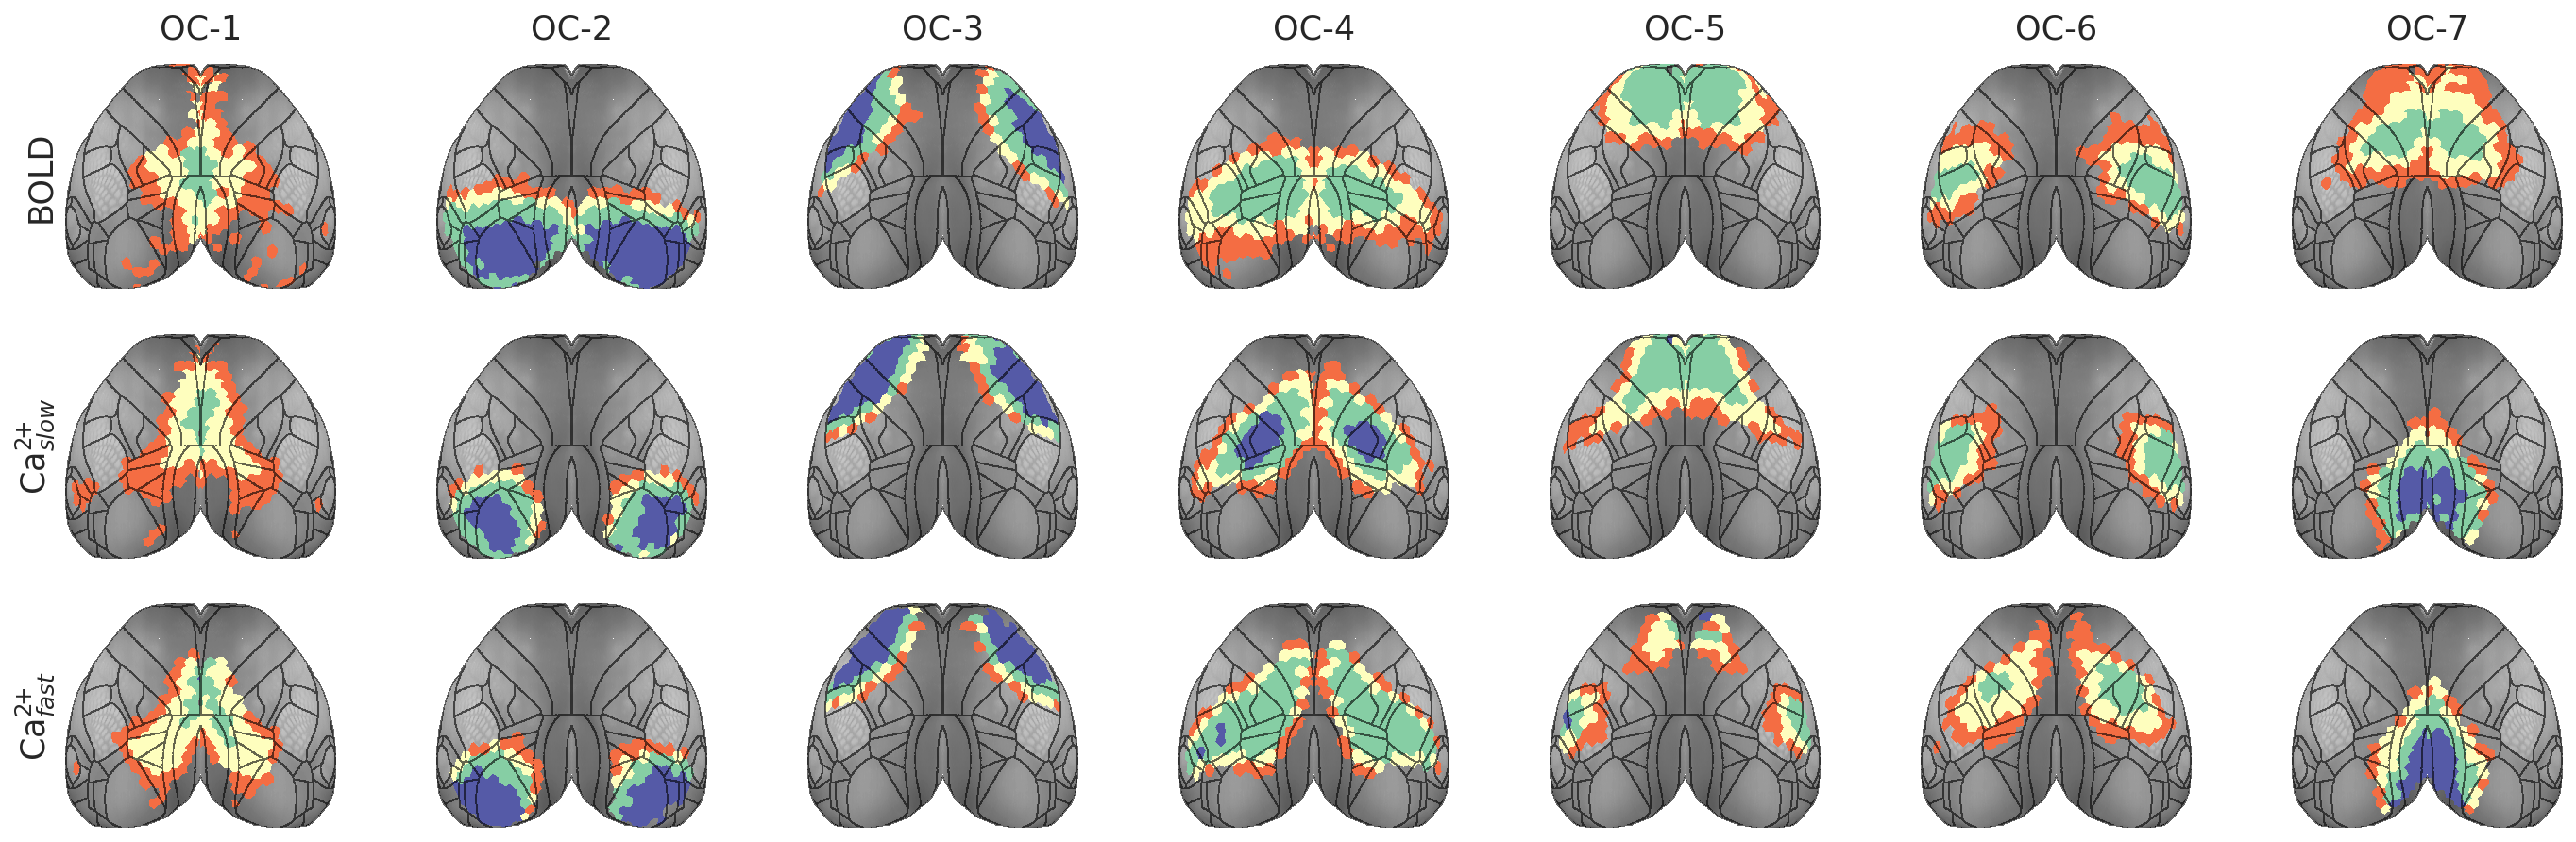

In [8]:
list(results['scores'])

['BOLD', 'Ca$^{2\\!\\!+}_{slow}$', 'Ca$^{2\\!\\!+}_{fast}$']

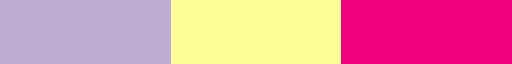

In [9]:
_, accent = mk_member_cmap(acc=[1, 3, 5])
accent

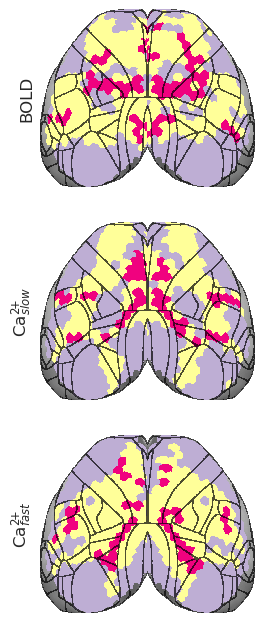

In [10]:
mu = np.round(1 / num_k, 3)

_ = bt.show(
    data={
        mode: d1[mu]['node_mem'] for
        mode, d1 in results['scores'].items()},
    vmin=1,
    vmax=4,
    cmap=accent,
    interp='none',
    mask_thresh=0.01,
    contour_coarse=False,
    contour_cmap='Greys_r',
    contour_alpha=0.7,
    figsize=(4.5, 8),
    dpi=100,
)

## Bar plot

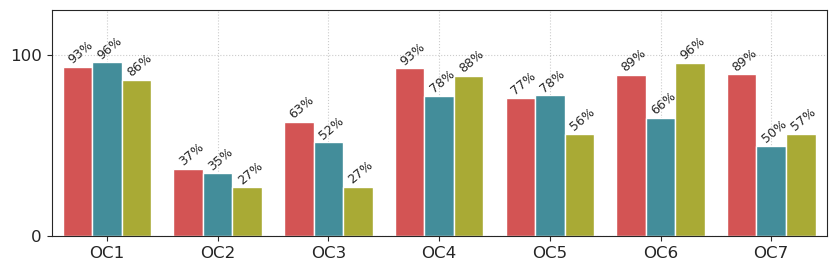

In [11]:
from figures.fig_mem import scores_bar as go
fig, _ = go(results, mu=mu)

fig.savefig(pjoin(fig_dir, f'bar_K{num_k}.pdf'), **kws_fig)
fig.savefig(pjoin(fig_dir, f'bar_K{num_k}.png'), **kws_fig)

## Pie

In [12]:
mode2lbl = {
    BOLD: 'BOLD',
    CAS: 'CAS',
    CAF: 'CAF',
}

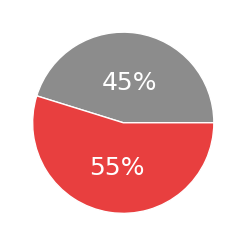

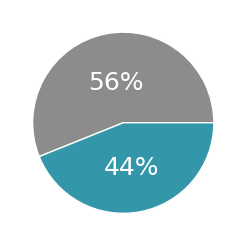

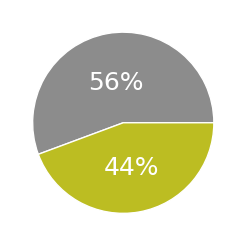

In [13]:
from figures.fig_mem import scores_pie as go
figs = go(results, mu=mu, radius={
    BOLD: (0.45, 0.5),
    CAS: (0.45, 0.5),
    CAF: (0.45, 0.5),
})
for mode, f in figs.items():
    f.savefig(pjoin(fig_dir, f'pie_K{num_k}_{mode2lbl[mode]}.pdf'), **kws_fig)
    f.savefig(pjoin(fig_dir, f'pie_K{num_k}_{mode2lbl[mode]}.png'), **kws_fig)
    display(f)

## Mem (column plots)

In [14]:
from figures.fighelper import ctx2ax

save_dir = pjoin(fig_dir, 'Mem')
os.makedirs(save_dir, exist_ok=True)
print(save_dir)

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512-p15/Fig5_Mem/Mem

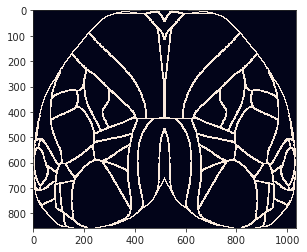

In [15]:
contour = bt.get_contour(0.2, False)
plt.imshow(contour);

### Spectral

In [16]:
kwargs = {
    'base': bt,
    'vmin': 1,
    'vmax': len(results['mu_vals']),
    'cbar': False,
    'cmap': spectral,
    'contour': contour,
    'contour_alpha': 0.6,
    'contour_cmap': 'Greys_r',
    'interp': 'antialiased',
}

In [17]:
for i in range(num_k):
    fig, axes = create_figure(
        nrows=3,
        ncols=1,
        figsize=(3, 7),
        sharex='all',
        sharey='all',
        tight_layout=False,
        constrained_layout=True,
    )
    for j, (mode, mem) in enumerate(results['members'].items()):
        x = mem[i].copy()
        x[x <= 0] = np.nan
        ctx2ax(x=x, ax=axes[j], **kwargs)
    remove_ticks(axes)
    fig.savefig(pjoin(save_dir, f'OC-{i+1}.png'), **kws_fig)
    plt.close()

### Accent

In [18]:
kwargs = {
    'base': bt,
    'vmin': 1,
    'vmax': len(accent.colors),
    'cbar': False,
    'cmap': accent,
    'contour': contour,
    'contour_alpha': 0.7,
    'contour_cmap': 'Greys_r',
    'interp': 'antialiased',
}

In [19]:
mu = np.round(1 / num_k, 3)
data = {
    mode: d1[mu]['node_mem'] for
    mode, d1 in results['scores'].items()
}
fig, axes = create_figure(
    nrows=3,
    ncols=1,
    figsize=(3, 7),
    sharex='all',
    sharey='all',
    tight_layout=False,
    constrained_layout=True,
)
for j, (mode, c) in enumerate(data.items()):
    x = c.copy()
    x[x <= 0] = np.nan
    ctx2ax(x=x, ax=axes[j], **kwargs)
remove_ticks(axes)
fig.savefig(pjoin(save_dir, 'C.png'), **kws_fig)
plt.close()

## Cbar accent save

In [32]:
fig_dir = 'Figs_Cbar'
fig_dir = pjoin(fig_base_dir, 'paper2.0', f'n{nn}-p{perc}', fig_dir)
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512-p15/Figs_Cbar

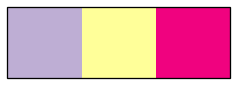

In [33]:
fig, cax, cbar = cbar_only(accent, vertical=False, figsize=(4, 1.3))
# cax.set_title('Numer of networks', y=1.07, fontsize=19)
cax.xaxis.set_visible(False)

fig.savefig(pjoin(fig_dir, f'accent_notick_3.png'), **kws_fig)
fig.savefig(pjoin(fig_dir, f'accent_notick_3.pdf'), **kws_fig)
fig

## Cbar France save

In [3]:
fig_dir = 'Figs_Cbar'
fig_dir = pjoin(fig_base_dir, 'paper2.0', f'n{nn}-p{perc}', fig_dir)
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512-p15/Figs_Cbar

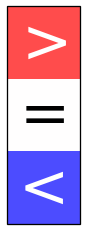

In [10]:
from figures.fig_deg import cbar_perm_test

bwr = sns.color_palette('bwr', as_cmap=True)
fig, cax, cbar = cbar_perm_test([bwr(0.15), bwr(0.5), bwr(0.85)])
# cax.set_title(r'$p < 0.05$', fontsize=18, y=1.06, rotation=0)

fig.savefig(pjoin(fig_dir, f'perm.png'), **kws_fig)
fig.savefig(pjoin(fig_dir, f'perm.pdf'), **kws_fig)
fig